In [2]:
!pip install onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import onnx
import onnxruntime as ort

In [ ]:

# --- 1. Hyperparameters ---
ONNX_MODEL_PATH = "lstm_food_freshness.onnx"
DATA_URL = "https://raw.githubusercontent.com/PenyelamatPangan/Models/main/food_freshness_dataset.csv"


SEQUENCE_LENGTH = 10  # How many time steps to look back
BATCH_SIZE = 64
NUM_EPOCHS = 30 # MODIFIED: Increased epochs
LEARNING_RATE = 0.001
HIDDEN_SIZE = 32      # MODIFIED: Simplified model
NUM_LAYERS = 1        # MODIFIED: Simplified model

# Loss weight balancing for multi-task learning
CLASSIFICATION_WEIGHT = 0.5  # Weight for binary classification loss
REGRESSION_WEIGHT = 0.5      # Weight for RSL regression loss



In [5]:

# --- 2. Helper Function to Create Sequences ---
def create_sequences(features, labels, seq_length):
    """
    Creates sliding window sequences from tabular data.
    """
    X_seq, y_seq = [], []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:(i + seq_length)])
        y_seq.append(labels[i + seq_length - 1]) # Label is from the last item in the window
    return np.array(X_seq), np.array(y_seq)

In [ ]:
print("Starting LSTM training and ONNX export...")

# --- 3. Load and Preprocess Data ---
print(f"Loading data from GitHub repository...")
try:
    df = pd.read_csv(DATA_URL)
    print(f"Successfully loaded data from: {DATA_URL}")
except Exception as e:
    print(f"Error loading data from GitHub: {e}")
    print("Please check your internet connection and the URL.")
    exit()

print(f"Loaded {len(df)} rows.")
print(f"Columns: {df.columns.tolist()}")

# Separate features (X) and labels (y)
# Updated to match new 3-sensor dataset structure with dual outputs
features = ['MQ135_Analog', 'MQ3_Analog', 'MiCS5524_Analog']
target_classification = 'Output'  # Binary: 0=bad, 1=fresh
target_regression = 'RSL_Hours'   # Continuous: 0-168 hours

X = df[features].values
y_class = df[target_classification].values
y_rsl = df[target_regression].values

print(f"Features shape: {X.shape}")
print(f"Classification labels shape: {y_class.shape}")
print(f"RSL labels shape: {y_rsl.shape}")
print(f"RSL range: {y_rsl.min():.0f} - {y_rsl.max():.0f} hours")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for both outputs
# This is the most important step for an LSTM
X_seq, y_class_seq = create_sequences(X_scaled, y_class, SEQUENCE_LENGTH)
_, y_rsl_seq = create_sequences(X_scaled, y_rsl, SEQUENCE_LENGTH)

print(f"Created {len(X_seq)} sequences of length {SEQUENCE_LENGTH}.")

# Split into training and testing sets
X_train_seq, X_test_seq, y_train_class, y_test_class, y_train_rsl, y_test_rsl = train_test_split(
    X_seq, y_class_seq, y_rsl_seq, test_size=0.2, random_state=42
)

# Convert to PyTorch Tensors
# Shape required for LSTM: (batch_size, sequence_length, num_features)
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_class_tensor = torch.tensor(y_train_class, dtype=torch.float32).view(-1, 1)
y_train_rsl_tensor = torch.tensor(y_train_rsl, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_class_tensor = torch.tensor(y_test_class, dtype=torch.float32).view(-1, 1)
y_test_rsl_tensor = torch.tensor(y_test_rsl, dtype=torch.float32).view(-1, 1)

print(f"Training sequences shape: {X_train_tensor.shape}")
print(f"Test sequences shape: {X_test_tensor.shape}")

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_class_tensor, y_train_rsl_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_class_tensor, y_test_rsl_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



Starting LSTM training and ONNX export...
Loaded 100000 rows from https://raw.githubusercontent.com/PenyelamatPangan/Models/main/food_freshness_dataset.csv.
Columns: ['MQ135_Analog', 'MQ3_Analog', 'MiCS5524_Analog', 'Output']
Features shape: (100000, 3)
Labels shape: (100000,)
Created 99990 sequences of length 10.
Training sequences shape: torch.Size([79992, 10, 3])
Test sequences shape: torch.Size([19998, 10, 3])


In [ ]:

# --- 4. Define the LSTM Model with Dual Outputs ---
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        # batch_first=True makes input shape (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.2 if num_layers > 1 else 0)

        # Output head 1: Binary Classification (Fresh vs Bad)
        self.fc_classification = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

        # Output head 2: RSL Regression (Remaining Shelf Life in hours)
        self.fc_regression = nn.Linear(hidden_size, 1)
        # No activation for regression output (linear)

    def forward(self, x):
        # Initialize hidden state and cell state
        # (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))

        # We only care about the output of the *last* time step
        out = out[:, -1, :]

        # Classification output (binary)
        classification_logits = self.fc_classification(out)
        
        # Regression output (RSL hours)
        regression_output = self.fc_regression(out)

        # During inference, apply sigmoid to classification
        if not self.training:
            classification_output = self.sigmoid(classification_logits)
            return classification_output, regression_output
        
        # During training, return raw logits for classification (for BCEWithLogitsLoss)
        return classification_logits, regression_output

# Instantiate model, losses, and optimizer
input_size = len(features)  # 3 features (MQ135, MQ3, MiCS5524)
print(f"Model input size: {input_size} features")

model = LSTMClassifier(input_size, HIDDEN_SIZE, NUM_LAYERS)

# Two loss functions for multi-task learning
criterion_classification = nn.BCEWithLogitsLoss()  # Binary classification
criterion_regression = nn.MSELoss()                # RSL regression

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Dual outputs: Binary Classification + RSL Regression")


Model input size: 3 features
Model created with 4769 parameters


In [ ]:

# --- 5. Train the Model (Multi-Task Learning) ---
print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Loss weights: Classification={CLASSIFICATION_WEIGHT}, Regression={REGRESSION_WEIGHT}")

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    total_class_loss = 0
    total_rsl_loss = 0
    
    for i, (seqs, labels_class, labels_rsl) in enumerate(train_loader):
        # Forward pass - get both outputs
        class_logits, rsl_output = model(seqs)
        
        # Calculate both losses
        loss_class = criterion_classification(class_logits, labels_class)
        loss_rsl = criterion_regression(rsl_output, labels_rsl)
        
        # Combined weighted loss
        loss = (CLASSIFICATION_WEIGHT * loss_class) + (REGRESSION_WEIGHT * loss_rsl)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_class_loss += loss_class.item()
        total_rsl_loss += loss_rsl.item()

    avg_loss = total_loss / len(train_loader)
    avg_class_loss = total_class_loss / len(train_loader)
    avg_rsl_loss = total_rsl_loss / len(train_loader)
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Total Loss: {avg_loss:.4f}, '
          f'Class Loss: {avg_class_loss:.4f}, RSL Loss: {avg_rsl_loss:.4f}')

print("Training complete.")


Starting training for 30 epochs...
Epoch [1/30], Loss: 0.0604
Epoch [2/30], Loss: 0.0009
Epoch [3/30], Loss: 0.0003
Epoch [4/30], Loss: 0.0001
Epoch [5/30], Loss: 0.0001
Epoch [6/30], Loss: 0.0000
Epoch [7/30], Loss: 0.0000
Epoch [8/30], Loss: 0.0000
Epoch [9/30], Loss: 0.0000
Epoch [10/30], Loss: 0.0000
Epoch [11/30], Loss: 0.0000
Epoch [12/30], Loss: 0.0000
Epoch [13/30], Loss: 0.0000
Epoch [14/30], Loss: 0.0000
Epoch [15/30], Loss: 0.0000
Epoch [16/30], Loss: 0.0000
Epoch [17/30], Loss: 0.0000
Epoch [18/30], Loss: 0.0000
Epoch [19/30], Loss: 0.0000
Epoch [20/30], Loss: 0.0000
Epoch [21/30], Loss: 0.0000
Epoch [22/30], Loss: 0.0000
Epoch [23/30], Loss: 0.0000
Epoch [24/30], Loss: 0.0000
Epoch [25/30], Loss: 0.0000
Epoch [26/30], Loss: 0.0000
Epoch [27/30], Loss: 0.0000
Epoch [28/30], Loss: 0.0000
Epoch [29/30], Loss: 0.0000
Epoch [30/30], Loss: 0.0000
Training complete.


In [ ]:

# --- 6. Evaluate the Model (Dual Outputs) ---
model.eval()
all_class_preds = []
all_class_labels = []
all_rsl_preds = []
all_rsl_labels = []

with torch.no_grad():
    for seqs, labels_class, labels_rsl in test_loader:
        # Get outputs (model returns sigmoid outputs in eval mode)
        class_output, rsl_output = model(seqs)

        # Classification: Apply threshold to get 0 or 1
        class_preds = (class_output > 0.5).float()

        all_class_preds.extend(class_preds.numpy())
        all_class_labels.extend(labels_class.numpy())
        all_rsl_preds.extend(rsl_output.numpy())
        all_rsl_labels.extend(labels_rsl.numpy())

# Classification metrics
accuracy = accuracy_score(all_class_labels, all_class_preds)
print(f"\n{'='*60}")
print("BINARY CLASSIFICATION RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(all_class_labels, all_class_preds, target_names=['Bad (0)', 'Fresh (1)']))

# Regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

all_rsl_preds = np.array(all_rsl_preds).flatten()
all_rsl_labels = np.array(all_rsl_labels).flatten()

mae = mean_absolute_error(all_rsl_labels, all_rsl_preds)
rmse = np.sqrt(mean_squared_error(all_rsl_labels, all_rsl_preds))
r2 = r2_score(all_rsl_labels, all_rsl_preds)

print(f"\n{'='*60}")
print("RSL REGRESSION RESULTS (Remaining Shelf Life)")
print(f"{'='*60}")
print(f"Mean Absolute Error (MAE): {mae:.2f} hours")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} hours")
print(f"R² Score: {r2:.4f}")

# Show sample predictions
print(f"\n{'='*60}")
print("SAMPLE PREDICTIONS")
print(f"{'='*60}")
print(f"{'Actual Class':<15} {'Pred Class':<15} {'Actual RSL':<15} {'Pred RSL':<15}")
print("-" * 60)
for i in range(min(10, len(all_class_labels))):
    actual_class = "Fresh" if all_class_labels[i] == 1 else "Bad"
    pred_class = "Fresh" if all_class_preds[i] == 1 else "Bad"
    print(f"{actual_class:<15} {pred_class:<15} {all_rsl_labels[i]:<15.0f} {all_rsl_preds[i]:<15.0f}")



Test Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

     Bad (0)       1.00      1.00      1.00      9927
   Fresh (1)       1.00      1.00      1.00     10071

    accuracy                           1.00     19998
   macro avg       1.00      1.00      1.00     19998
weighted avg       1.00      1.00      1.00     19998



In [ ]:

# --- 7. Export to ONNX (Dual Outputs) ---
print(f"\nExporting model to {ONNX_MODEL_PATH}...")

# Set model to evaluation mode (important for ONNX)
model.eval()

# Create a dummy input matching the model's input shape
# (batch_size, sequence_length, num_features)
# We use a batch size of 1 for the dummy input
dummy_input = torch.randn(1, SEQUENCE_LENGTH, input_size, requires_grad=True)

# Export the model
torch.onnx.export(
    model,                          # The model to export
    dummy_input,                    # A dummy input
    ONNX_MODEL_PATH,                # Where to save the model
    export_params=True,             # Store the trained weights
    opset_version=11,               # ONNX version
    do_constant_folding=True,       # Optimization
    input_names=['input_sequence'], # Name for the input
    output_names=['classification_output', 'rsl_output'],  # Names for dual outputs
    dynamic_axes={                  # --- VERY IMPORTANT ---
        'input_sequence': {0: 'batch_size'}, # Allows variable batch size
        'classification_output': {0: 'batch_size'},
        'rsl_output': {0: 'batch_size'}
    }
)

print(f"Successfully exported model to {ONNX_MODEL_PATH}")

# (Optional) Verify the ONNX model
print("Verifying ONNX model...")
onnx_model = onnx.load(ONNX_MODEL_PATH)
onnx.checker.check_model(onnx_model)

# Test with ONNX Runtime
ort_session = ort.InferenceSession(ONNX_MODEL_PATH)
ort_inputs = {ort_session.get_inputs()[0].name: dummy_input.detach().numpy()}
ort_outs = ort_session.run(None, ort_inputs)

print(f"ONNX model verification successful!")
print(f"  Output 1 (Classification) shape: {ort_outs[0].shape}")
print(f"  Output 2 (RSL) shape: {ort_outs[1].shape}")



Exporting model to lstm_food_freshness.onnx...
Successfully exported model to lstm_food_freshness.onnx
Verifying ONNX model...
ONNX model verification successful. Inference test output shape: (1, 1)


/tmp/ipython-input-1477254319.py:13: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


**TESTING**

In [26]:

# Sensor columns (3 analog sensors)
SENSOR_COLUMNS = ['MQ135_Analog', 'MQ3_Analog', 'MiCS5524_Analog']

In [27]:
# --- Load ONNX Model ---
print(f"Loading ONNX model from {ONNX_MODEL_PATH}...")
ort_session = ort.InferenceSession(ONNX_MODEL_PATH)

# Get model input details
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

print(f"Model loaded successfully!")
print(f"Input name: {input_name}")
print(f"Output name: {output_name}")
print(f"Expected input shape: (batch_size, {SEQUENCE_LENGTH}, {len(SENSOR_COLUMNS)})")

Loading ONNX model from lstm_food_freshness.onnx...
Model loaded successfully!
Input name: input_sequence
Output name: output
Expected input shape: (batch_size, 10, 3)


In [ ]:
# --- Load and Prepare Test Data ---
print(f"\nLoading test data from GitHub repository...")
df = pd.read_csv(DATA_URL)
print(f"Loaded {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")

# Display sample data
print("\nFirst 5 rows:")
print(df.head())

# Display value distribution
print("\nOutput distribution:")
print(df['Output'].value_counts())



Loading test data from https://raw.githubusercontent.com/PenyelamatPangan/Models/main/food_freshness_dataset.csv...
Loaded 100000 rows
Columns: ['MQ135_Analog', 'MQ3_Analog', 'MiCS5524_Analog', 'Output']

First 5 rows:
   MQ135_Analog  MQ3_Analog  MiCS5524_Analog  Output
0           240         290              262       1
1           784         922              632       0
2           285         256              162       1
3           682         961              674       0
4           255         149              129       1

Output distribution:
Output
1    50000
0    50000
Name: count, dtype: int64


In [29]:
# --- Prepare Scaler (fit on all data for testing purposes) ---
X = df[SENSOR_COLUMNS].values
y = df['Output'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nData scaled. Shape: {X_scaled.shape}")
print(f"Feature means: {scaler.mean_}")
print(f"Feature std devs: {scaler.scale_}")


Data scaled. Shape: (100000, 3)
Feature means: [466.5782  482.30294 465.48423]
Feature std devs: [272.79181063 288.34260061 261.06253889]


In [ ]:
# --- Function to Create Sequences ---
def create_test_sequence(data, start_idx, seq_length=10):
    """
    Create a single sequence from the data starting at start_idx.
    Returns shape (1, seq_length, num_features) for model input.
    """
    if start_idx + seq_length > len(data):
        raise ValueError(f"Not enough data. Need {seq_length} samples from index {start_idx}")

    sequence = data[start_idx:start_idx + seq_length]
    # Reshape to (1, seq_length, num_features) for batch size of 1
    return sequence.reshape(1, seq_length, -1).astype(np.float32)

# --- Function to Make Prediction (Dual Outputs) ---
def predict(sequence):
    """
    Make prediction using ONNX model.
    Returns classification probability, class label, and RSL hours.
    """
    ort_inputs = {input_name: sequence}
    ort_outputs = ort_session.run(None, ort_inputs)
    
    # Output 1: Classification
    classification_prob = ort_outputs[0][0][0]
    classification_pred = 1 if classification_prob > 0.5 else 0
    
    # Output 2: RSL
    rsl_hours = max(0, ort_outputs[1][0][0])  # Ensure non-negative
    
    return classification_prob, classification_pred, rsl_hours


In [31]:
# --- Test with Custom Sensor Values ---
print("\n" + "="*60)
print("Testing with Custom Sensor Values")
print("="*60)

# Example 1: Fresh food readings (low analog values)
fresh_readings = np.array([
    [150, 120, 180],  # MQ135, MQ3, MiCS5524
    [145, 125, 175],
    [160, 130, 185],
    [155, 128, 180],
    [148, 122, 178],
    [152, 127, 182],
    [158, 131, 188],
    [151, 124, 179],
    [149, 126, 181],
    [153, 129, 183]
])

# Scale the custom data
fresh_scaled = scaler.transform(fresh_readings)
fresh_sequence = fresh_scaled.reshape(1, SEQUENCE_LENGTH, -1).astype(np.float32)

# Predict
prob, pred = predict(fresh_sequence)
print("\nTest Case 1: Fresh Food (Low Gas Levels)")
print(f"  Sensor readings (avg): MQ135={fresh_readings[:, 0].mean():.1f}, MQ3={fresh_readings[:, 1].mean():.1f}, MiCS5524={fresh_readings[:, 2].mean():.1f}")
print(f"  Prediction: {pred} ({'Fresh' if pred == 1 else 'Bad'})")
print(f"  Probability (Fresh): {prob:.4f}")

# Example 2: Spoiled food readings (high analog values)
spoiled_readings = np.array([
    [650, 720, 680],  # MQ135, MQ3, MiCS5524
    [670, 740, 695],
    [690, 760, 710],
    [680, 750, 700],
    [675, 735, 690],
    [685, 755, 705],
    [695, 770, 715],
    [688, 748, 698],
    [677, 742, 692],
    [683, 752, 703]
])

# Scale the custom data
spoiled_scaled = scaler.transform(spoiled_readings)
spoiled_sequence = spoiled_scaled.reshape(1, SEQUENCE_LENGTH, -1).astype(np.float32)

# Predict
prob, pred = predict(spoiled_sequence)
print("\nTest Case 2: Spoiled Food (High Gas Levels)")
print(f"  Sensor readings (avg): MQ135={spoiled_readings[:, 0].mean():.1f}, MQ3={spoiled_readings[:, 1].mean():.1f}, MiCS5524={spoiled_readings[:, 2].mean():.1f}")
print(f"  Prediction: {pred} ({'Fresh' if pred == 1 else 'Bad'})")
print(f"  Probability (Fresh): {prob:.4f}")


Testing with Custom Sensor Values

Test Case 1: Fresh Food (Low Gas Levels)
  Sensor readings (avg): MQ135=152.1, MQ3=126.2, MiCS5524=181.1
  Prediction: 1 (Fresh)
  Probability (Fresh): 1.0000

Test Case 2: Spoiled Food (High Gas Levels)
  Sensor readings (avg): MQ135=679.3, MQ3=747.2, MiCS5524=698.8
  Prediction: 0 (Bad)
  Probability (Fresh): 0.0000


In [32]:
# --- Batch Prediction for Visualization ---
print("\n" + "="*60)
print("Running Batch Predictions for Visualization")
print("="*60)

# Test on first 100 sequences
num_samples = min(100, len(X_scaled) - SEQUENCE_LENGTH)
predictions = []
actuals = []
probabilities = []

for i in range(num_samples):
    test_seq = create_test_sequence(X_scaled, i, SEQUENCE_LENGTH)
    prob, pred = predict(test_seq)
    actual = y[i + SEQUENCE_LENGTH - 1]

    predictions.append(pred)
    actuals.append(actual)
    probabilities.append(prob)

# Calculate accuracy
correct = sum(p == a for p, a in zip(predictions, actuals))
accuracy = correct / len(predictions) * 100

print(f"\nTested {num_samples} sequences")
print(f"Accuracy: {accuracy:.2f}% ({correct}/{len(predictions)})")


Running Batch Predictions for Visualization

Tested 100 sequences
Accuracy: 100.00% (100/100)


In [34]:
# Install required packages if needed
!pip install onnxruntime pandas numpy scikit-learn

In [36]:
import numpy as np
import pandas as pd
import onnxruntime as ort
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

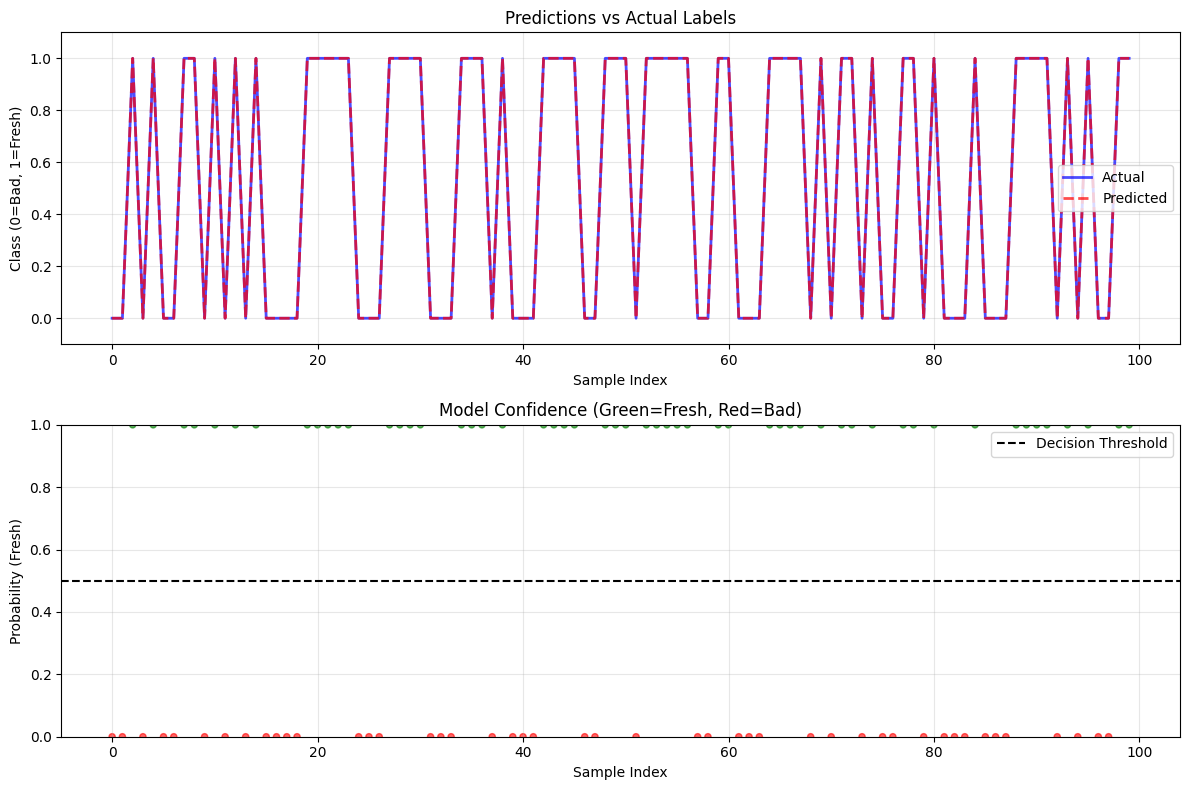


Visualization complete!


In [37]:
# --- Visualization ---
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Predictions vs Actuals
axes[0].plot(actuals, 'b-', label='Actual', alpha=0.7, linewidth=2)
axes[0].plot(predictions, 'r--', label='Predicted', alpha=0.7, linewidth=2)
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Class (0=Bad, 1=Fresh)')
axes[0].set_title('Predictions vs Actual Labels')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([-0.1, 1.1])

# Plot 2: Prediction Probabilities
colors = ['red' if p < 0.5 else 'green' for p in probabilities]
axes[1].scatter(range(len(probabilities)), probabilities, c=colors, alpha=0.6, s=20)
axes[1].axhline(y=0.5, color='black', linestyle='--', label='Decision Threshold')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Probability (Fresh)')
axes[1].set_title('Model Confidence (Green=Fresh, Red=Bad)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"\nVisualization complete!")

In [38]:
# --- Simulate Real-Time Sensor Reading Buffer ---
class SensorBuffer:
    """
    Maintains a rolling buffer of sensor readings for LSTM prediction.
    This simulates what you'd implement on Arduino/microcontroller.
    """
    def __init__(self, buffer_size=10, scaler=None):
        self.buffer_size = buffer_size
        self.buffer = []
        self.scaler = scaler

    def add_reading(self, mq135, mq3, mics5524):
        """Add new sensor reading to buffer."""
        reading = [mq135, mq3, mics5524]
        self.buffer.append(reading)

        # Keep only last buffer_size readings
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)

    def is_ready(self):
        """Check if buffer has enough readings for prediction."""
        return len(self.buffer) >= self.buffer_size

    def get_sequence(self):
        """Get scaled sequence ready for prediction."""
        if not self.is_ready():
            return None

        # Convert to numpy array
        sequence = np.array(self.buffer[-self.buffer_size:])

        # Scale using fitted scaler
        if self.scaler:
            sequence = self.scaler.transform(sequence)

        # Reshape for model input
        return sequence.reshape(1, self.buffer_size, -1).astype(np.float32)

# Test the buffer
print("\n" + "="*60)
print("Testing Real-Time Sensor Buffer")
print("="*60)

buffer = SensorBuffer(buffer_size=SEQUENCE_LENGTH, scaler=scaler)

# Simulate adding readings one by one (like Arduino loop)
print("\nSimulating real-time sensor readings...\n")

# Fresh food simulation
print("Scenario: Fresh food (low gas levels)")
for i in range(12):  # Add 12 readings
    # Simulate fresh food readings with slight variation
    mq135 = np.random.randint(140, 160)
    mq3 = np.random.randint(120, 135)
    mics5524 = np.random.randint(175, 190)

    buffer.add_reading(mq135, mq3, mics5524)
    print(f"  Reading {i+1}: MQ135={mq135}, MQ3={mq3}, MiCS5524={mics5524}")

    # Try to predict once buffer is ready
    if buffer.is_ready():
        sequence = buffer.get_sequence()
        prob, pred = predict(sequence)
        print(f"    → Prediction: {pred} ({'Fresh' if pred == 1 else 'Bad'}), Confidence: {prob:.2%}\n")

# Reset buffer for spoiled food test
buffer = SensorBuffer(buffer_size=SEQUENCE_LENGTH, scaler=scaler)

print("\nScenario: Spoiled food (high gas levels)")
for i in range(12):  # Add 12 readings
    # Simulate spoiled food readings with slight variation
    mq135 = np.random.randint(650, 700)
    mq3 = np.random.randint(720, 770)
    mics5524 = np.random.randint(680, 720)

    buffer.add_reading(mq135, mq3, mics5524)
    print(f"  Reading {i+1}: MQ135={mq135}, MQ3={mq3}, MiCS5524={mics5524}")

    # Try to predict once buffer is ready
    if buffer.is_ready():
        sequence = buffer.get_sequence()
        prob, pred = predict(sequence)
        print(f"    → Prediction: {pred} ({'Fresh' if pred == 1 else 'Bad'}), Confidence: {prob:.2%}\n")


Testing Real-Time Sensor Buffer

Simulating real-time sensor readings...

Scenario: Fresh food (low gas levels)
  Reading 1: MQ135=156, MQ3=120, MiCS5524=179
  Reading 2: MQ135=149, MQ3=134, MiCS5524=177
  Reading 3: MQ135=140, MQ3=126, MiCS5524=183
  Reading 4: MQ135=156, MQ3=128, MiCS5524=185
  Reading 5: MQ135=153, MQ3=120, MiCS5524=176
  Reading 6: MQ135=152, MQ3=132, MiCS5524=181
  Reading 7: MQ135=159, MQ3=132, MiCS5524=180
  Reading 8: MQ135=150, MQ3=131, MiCS5524=175
  Reading 9: MQ135=144, MQ3=131, MiCS5524=177
  Reading 10: MQ135=141, MQ3=120, MiCS5524=177
    → Prediction: 1 (Fresh), Confidence: 100.00%

  Reading 11: MQ135=141, MQ3=127, MiCS5524=187
    → Prediction: 1 (Fresh), Confidence: 100.00%

  Reading 12: MQ135=143, MQ3=121, MiCS5524=189
    → Prediction: 1 (Fresh), Confidence: 100.00%


Scenario: Spoiled food (high gas levels)
  Reading 1: MQ135=652, MQ3=764, MiCS5524=697
  Reading 2: MQ135=699, MQ3=751, MiCS5524=713
  Reading 3: MQ135=676, MQ3=764, MiCS5524=699
  